In [9]:
# the goal of this challenge is to build a model that predicts conversion rate and, based on
# the model, come up with ideas to improve revenue

# the data revolution has a lot to do with the dact that now we are able to collect all sorts
# of data about people who byy something on our site as well as people who don't. This gives us
# a tremendous opportunity to understand what's working well (and potentially scale it even further)
# and what's not working well.

# we have data about users who hit our site: whether they converted or not as well as some
# of their characteristics such as their country, the marketing channel, their age, whether
# they are repeat users and the number of pages visited during that session as a proxy for 
# site activity/time spent on site

In [88]:
# import libraries
import warnings
# warnings filter controls whether warnings are ignored, displayed or turned into errors(raising an exception)
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, classification_report
# the metrics module implements functions assessing prediction error for specific purposes. These metrics are detailed in
# sections on Classification metrics, Multilabel ranking metrics, Regression metrics and Clustering metrics

from sklearn import preprocessing
#The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature
#vectors into a representation that is more suitable for the downstream estimators

from sklearn.model_selection import train_test_split
# split arrays or matrics into random train and test subsets
# train_test_split *array **options
# *array: allowed inputs are lists, numpy arrays, scipy-sparse matrices and pandas dataframes
# test_size: 0-1 by default 0.25 train_size: 0-1: if None, the value is automatically set to the complement of the 
# test size
# randome_state: controls the shuffling applied to the data before applying the split. Pass an int for reproducible 
# output across multiple function calls
# shuffle: whether or not to shuffle the data before splitting. If shuffle = False then stratify must be None
# stratify: array_like if not None, data is split in a stratifies fashion, using this as the class labels
# returns: splitting: list, length=2*len(arrays) list containing train-test split of inputs

from sklearn.ensemble import RandomForestClassifier
# the sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: theRandomForest
# algorithm and the Extra-Trees method. This means a diverse set of classifiers is created by introducting 
# randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction 
# of the individual classifiers
# As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of size
# [n_samples,n_features] holding the training samples, and an array Y of size [n_samples] holding the target
# values(class labels) for the training samples

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")
# encode categorical features as a one-hot numeric
# parameters: categories: list: categories[i] holds the categories expected in the ith column. The passed categories
# should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values
# drop: specifies a methodolofy to use to drop one of the categories per feature. This is useful in situations where
# perfectly collinear features casue problems, such as when feeding the resulting data into a neural network or an 
# unregularized regression. 
# However, dropping one category breaks the symmetry of the original representation and can therefore induce a bias
# in downstream models, for instance for penalized linear classification or regression models
# handle_unknown: whether to raise an error or ignore if an unknow categorical feature is present during transform
# (default is to raise). When this parameter is set to "ignore" and an unknown category is encountered during transform,
# the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown cartegory
# will be denoted as None
# methods: fit;fit_transform;get_feature_names;get_params;inverse_transform(convert the data back to the original representation)
# set_params;transform

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import spearmanr

from scipy.cluster import hierarchy

%matplotlib inline
# with this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

# H2o document
# H2o is a Java-based software for data modeling and general computing. The H2o software is many things, but the primary
# purpose of H2o is as a distrbuted (many machines),parallel(many CPUs), in memory(several hundred GBs) processing engine


In [11]:
# Are categorical variable getting lost in your random forests
# decision tree models can handle categorical variables without one-hot encoding them. However, popular implmentations
# of deicision trees (and random forests) differ as to whether they honor this fact. We show that one-hot encoding
# can seriously degrade tree-model performance. Our primary comparison is between H2o(which honors categorical variables)
# and scikit-learn(which requires them to be one-hot encoded)
# unnecessary one-hot encoding: many real-world datasets include a mix of continuous and categorical varaibles. 
# A major advantage of decision tree models and their ensemble counterparts, random forests, is that they are able to
# operate on both contiuous and categorical variables directly. In contrast. most other popular models
# (e.g., generalized linear model,neural networks) must instead transform categorical variables into some numerical
# analog, usually by one-hot encoding then to create a new dummy variable for each level of the original variable

# one-hot encoding can lead to a huge increase in the dimensionality of the feature representations. For example,
# one-hot endoing U.S. states adds 49 dimensions to the intuitive feature representation. In addition, one-hot encoding
# erases important structure in the underlying representation by splitting a single feature into many separate ones

In [12]:
# missing values in a random forest
# RCF: Random Forest Classifiers (RFCs). A RFC is a collection of trees, each indenpendently grown using labeled
# and complete input traning data. By complete we explicitly mean that there are no missing values i.e.Null or Nan
# values. But in practice the data often can have (many) missing values. In particular, very predictive features
# does not always have values available so they must be imputed before a random forest can be trained

# typically, random forest methods/packages encourage two ways of handling missing values:
# a) drop data points with missing values (not recommended)
# b) fill in missing values with the median(for numerical values) or mode(for categorical values)
# c) repeated iteration of random forest training to compute proximities
     # what we propose is a one-step pre-computation method which normalizes features to contruct a distance metric
     # for filling in missing values iwth the median of their k-nearest neighbors

In [13]:
# difference between Classifier and Regressor
# A Classifier is used to predict a set of specified labels
# example: email spam detection where we will always want to classify whether an email is either spam(1) or not spam(0)
# A Regressor is used to predict real valued outputs which vaey and don't require outputs predicted to be in a fixed set
# example: predicting the future income of resturants. We don;t know all the possible outputs.

In [14]:
# Comparison of Grid Search and Randomized Search Using Scikit Learn
# In contrast to model parameters which are learned during training, model hyperparameters are set by the data scientist
# ahead of training and control implementation aspects of the model
# In the case of random forest, hyperparameters include the number of decision trees in the forest and the number of 
# features considered by each tree when splitting a node (The parameters of a random forest are the variables and 
# thresholds used to split each node learned during traning)

# Grid Search can be thought of as an exhaustive search for selecting a model. 
# in Grid Search, the data scientist sets up a grid of hyperparameter values and for each combination
# trains a model and scores on the testing data. In this approach, every combination of hyperparameter
# values is tried which can be very inefficient
# e.g. searching 20 different parameter values for each of 4 parameters will require 160000 trials of 
# cross validation. This equates to 1600000 model fits and 1600000 predictions if 10 fold creoss validation is used
# While Scikit learn offers the GridSearchCV function to simplify the process, it would be an extremely
# costly execution both in computing power and time

# Random Search sets up a grid of hyperparameter values and select random combinations to train the model and score.
# This allows you to explicitly control the number of parameter combinations that are attempted. 
# The number of seach iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function
# for this process

# While it is possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, it surprisingly
# picks the best result more often than not and in a fraction of the time it takes GridSearchCV have taken.

In [15]:
# important hyperparameters we could try to adjust:
# n_estimators = number of trees in the forest
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

In [16]:
# feature engineering is the process of transforming raw data into useful features 
# thagt help us to understand our model better and increase its predictie power. 

In [17]:
# import dataset
data=pd.read_csv('/Users/.../Desktop/ds take home/A collection of Data Science take-home challenge/Conversion Rate/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [18]:
data.info()
#summary of dataframe
#list of all columns with their data types and the number of non-null values in each column. 
#we also have the value of rangeindex provided for the index axis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [19]:
data.describe()
# a large number of methods collectivey compute descriptive statistics and other related operations
# on data frame
# 'include' is the argument which is used to pass necessary information regarding what columns
# need to be considered for summarizing. By default, 'number'
# object - Summarizes String Columns
# number-Summarizes Numeric Columns
# all-Summarizes all columns together

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [20]:
data.describe(include="all")
# for string type, it includes unique, top, and freq

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [21]:
# show unique values and related numbers
# we only show first 5 values
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column,len(uniques)),uniques[:5])
# 5d formats an integer(d) to a field of minimum width 5
# 20s string length is 20

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [22]:
# remove outliers
# age should be below 100
data[data['age']>90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [23]:
# there are only two records that is valid, let us first remove them directly
data = data[data["age"]<100]

In [24]:
# Exploratory data analysis
# Visualization of different countries
grouped = data[['country','converted']].groupby('country').mean().reset_index()
grouped.head()

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


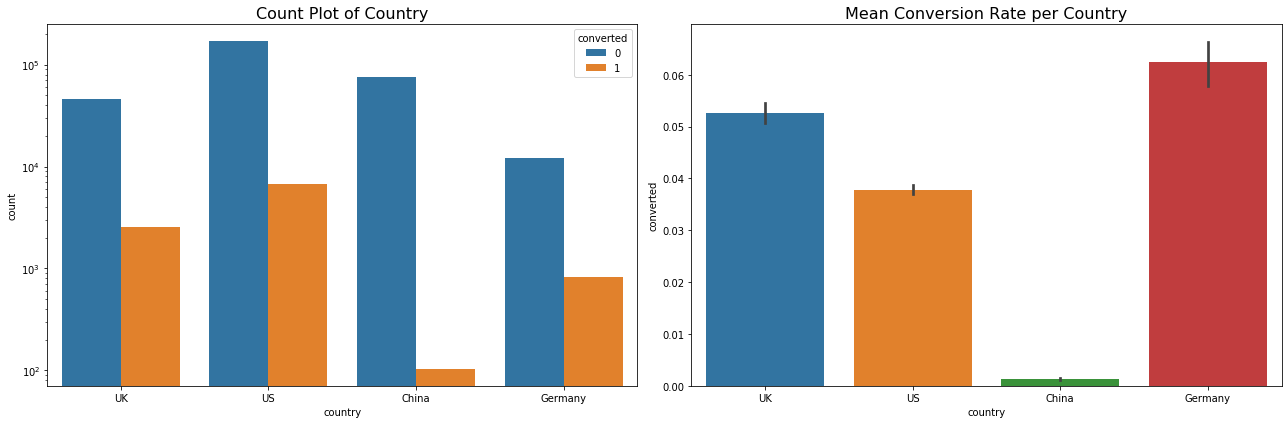

In [25]:
# plot mean conversion and count conversion for different countries
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x="country",hue="converted",data=data,ax=ax[0])
# in seaborn, the hue parameter determines which column in the data frame should be used for colour encoding. 
# Adding hue="converted" tells seaborn you want to color the data points for smoker and non-smoker differently
# this is for categorical data;
# also it adds a label
ax[0].set_title("Count Plot of Country",fontsize=16)
ax[0].set_yscale('log')
# y scale changes, the graph looks differently
sns.barplot(x="country",y="converted",data=data,ax=ax[1]);
ax[1].set_title("Mean Conversion Rate per Country", fontsize=16)
plt.tight_layout()
plt.show()
# axes object are position rect [left, bottom, width, height]

In [26]:
# Categorical Visualization: less unqiue values => barchart/countplot

# Visualization of different user types
grouped = data[["new_user","converted"]].groupby("new_user").mean().reset_index()
grouped.head()

,new_user,converted
0,0,0.071983
1,1,0.014021


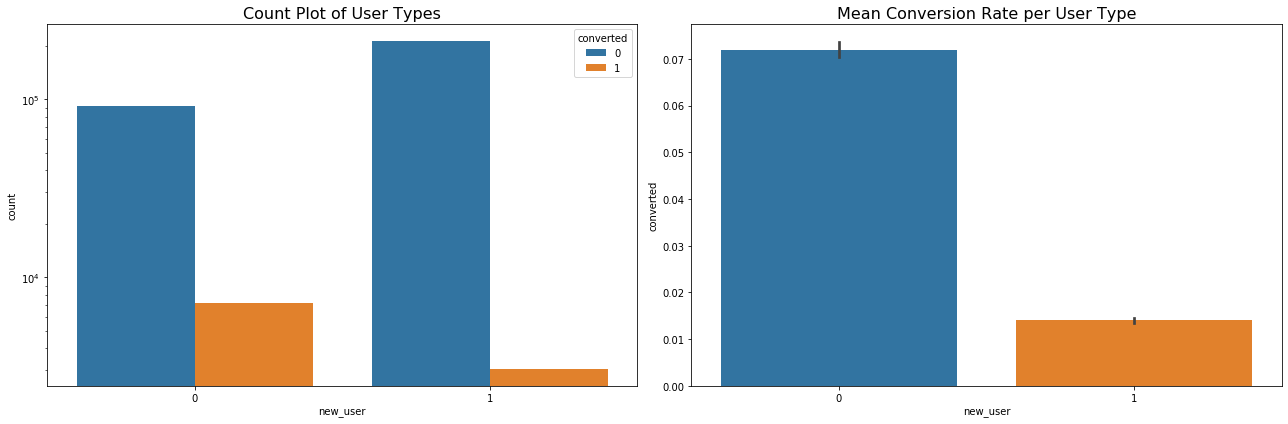

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x="new_user",hue="converted",data=data,ax=ax[0])
ax[0].set_title("Count Plot of User Types",fontsize=16)
ax[0].set_yscale("log")
sns.barplot(x="new_user",y="converted",data=data,ax=ax[1])
ax[1].set_title("Mean Conversion Rate per User Type",fontsize=16)
plt.tight_layout()
plt.show()
# batplot: it is important to keep in mind that a bar plot shows only the mean (or other estimator) value, 
# but in many cases it may be more informative to show the distribution of values at each level of the categorical
# vaeiables. In that case, other approaches such as a box or violin plot may be more appropriate

In [28]:
# Visualization of different sources
grouped = data[['source','converted']].groupby("source").mean().reset_index()
grouped.head()

,source,converted
0,Ads,0.034472
1,Direct,0.028169
2,Seo,0.032888


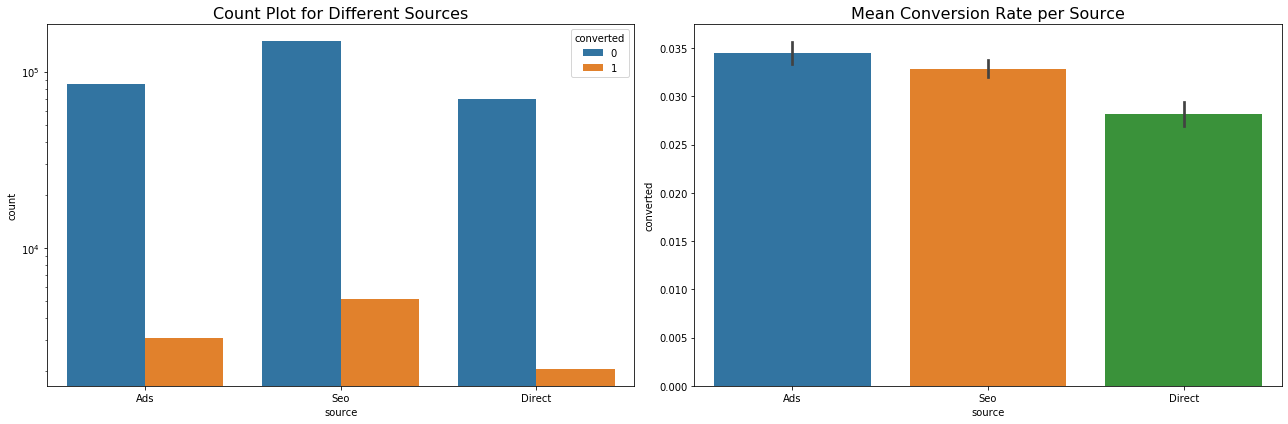

In [29]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x="source",hue="converted",data=data,ax=ax[0])
ax[0].set_title("Count Plot for Different Sources",fontsize=16)
ax[0].set_yscale("log")
sns.barplot(x="source",y="converted",data=data,ax=ax[1]);
ax[1].set_title("Mean Conversion Rate per Source",fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
# Categorical Visualization: more unique values/ ordered data points => distribution/histogram
                            #line graph for the mean value

# Visualization of different age
grouped = data[["age","converted"]].groupby("age").mean().reset_index()
grouped.head(20)

,age,converted
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985
5,22,0.053243
6,23,0.047990
7,24,0.045448
8,25,0.038782
9,26,0.039767


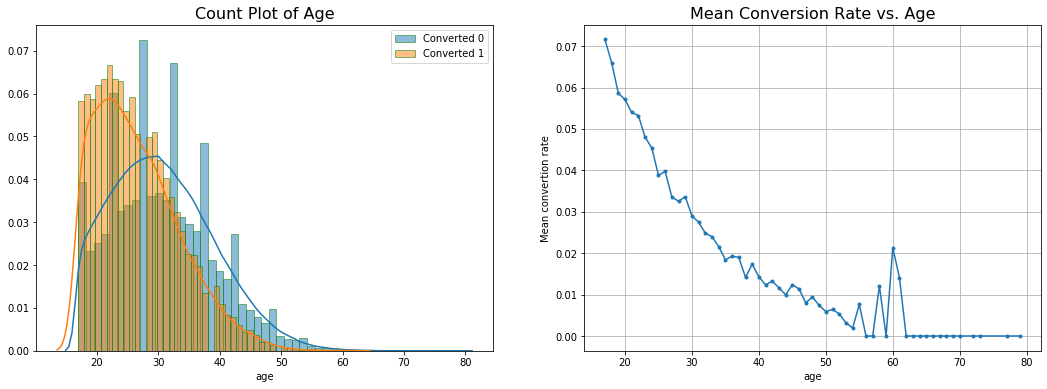

In [31]:
hist_kws={"histtype":"bar","edgecolor":"green","alpha":0.5}
# histtype {"bar","barstacked","step","stepfilled"}, by default "bar"
# edgecolor: an edge coloring of a graph is an assignment of "colors" to the edges of the graph 
# alpha: transpancy
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(data[data["converted"]==0]["age"],label="Converted 0", ax=ax[0],hist_kws=hist_kws)
sns.distplot(data[data["converted"]==1]["age"],label="Converted 1", ax=ax[0],hist_kws=hist_kws)
# seaborn.distplot flexibly plot a univariate distribution of observations
# seaborn.distplot parameters: a,bins=None,hist=True,kde=True,rug=False,fit=None,hist_kws=Hone,kde_kws=None
# rug_kws=None, fit_kws=None, color = None, vertical = False, norm_hist=False, axlabel=None, ax = None
# hist_kws: dict,optinal key arguments for matplotlin.axes.Axes.hist()
ax[0].set_title("Count Plot of Age",fontsize=16)
ax[0].legend()
ax[1].plot(grouped["age"],grouped["converted"],".-")
ax[1].set_title("Mean Conversion Rate vs. Age", fontsize=16)
ax[1].set_xlabel("age")
ax[1].set_ylabel("Mean convertion rate")
ax[1].grid(True)
# .grid() decide whether we have a grid lines on the graph
plt.show()

In [32]:
# Visualization of different sources/total_pages_visited
grouped = data[["total_pages_visited","converted"]].groupby("total_pages_visited").mean().reset_index()
grouped.head()

,total_pages_visited,converted
0,1,0.000000
1,2,0.000228
2,3,0.000251
3,4,0.000780
4,5,0.001570


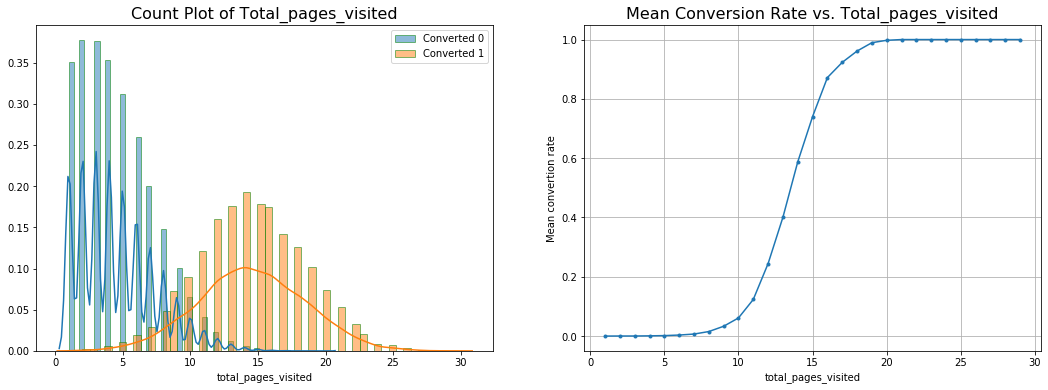

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
# figsize width 18 length 6
sns.distplot(data[data["converted"]==0]["total_pages_visited"],label="Converted 0", ax=ax[0],hist_kws=hist_kws)
sns.distplot(data[data["converted"]==1]["total_pages_visited"],label="Converted 1", ax=ax[0],hist_kws=hist_kws)
ax[0].set_title("Count Plot of Total_pages_visited", fontsize=16)
ax[0].legend()
ax[1].plot(grouped["total_pages_visited"],grouped["converted"],".-")
ax[1].set_title("Mean Conversion Rate vs. Total_pages_visited",fontsize=16)
ax[1].set_xlabel("total_pages_visited")
ax[1].set_ylabel("Mean convertion rate")
ax[1].grid(True)
plt.show()

In [64]:
# percentage of missing values
percent_missing=data.isnull().sum()*100/len(data)
missing_value=pd.DataFrame({"column_name":data.columns,"percent_missing":percent_missing})
missing_value.sort_values("percent_missing")
# when inplace=True is passed, the data is renamed in palce (it returns nothing); 
# when inplace=Flase(this is the default value) is passed, performs the operation and returns a copy of the object
missing_value
# there is no missing values in this project

,column_name,percent_missing
country,country,0.0
age,age,0.0
new_user,new_user,0.0
source,source,0.0
total_pages_visited,total_pages_visited,0.0
converted,converted,0.0


In [35]:
# encoding categorical features
# one-hot encoding: this is where the integer encoded variable is removed and a new binary variable 
# is added for each unique integer value. 
temp1=enc.fit_transform(data[["country","source"]]).toarray()
column_name=enc.get_feature_names(["country","source"])
enc_data=pd.DataFrame(temp1,columns=column_name)
enc_data2=data.join(enc_data)
enc_data3=enc_data2.drop(["country","source"],axis=1)
enc_data3.head()
enc_data3.columns

Index(['age', 'new_user', 'total_pages_visited', 'converted', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

In [65]:
# Predictive Modeling
# Split into 70% training and 30% test dataset
X=enc_data3.drop(["converted"],axis=1)
Y=enc_data3[["converted"]]
X_train,X_test,Y_train,Y_test = train_test_split(X,data["converted"],test_size=0.3,random_state=1234)
feature=[]
for col in enc_data3.columns:
    if col !="converted":
        feature.append(col)
print(feature)
target="converted"
# reshape numpy(n,) vector to (n,1) vector
Y_train=Y_train.values.reshape(-1,1)
Y_test=Y_test.values.reshape(-1,1)
# this extracts a numpy array with the values of your pandas Series object and then reshapes it to a 2D array

['age', 'new_user', 'total_pages_visited', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']


In [37]:
# hyperparameter tunning: RandomizedSearchCV

# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start=200,stop=2000,num=10)]
# numpy.linspace return evenly spaced numbers over a specified interval
# the endpoint of the interval can optionally be excluded; returns ndarray

#Number of features to consider at every split
max_features = ["auto","log2"]
# max_features:{"auto","sqrt","log2"}, int or float, default="auto"
# int: consider max_features features at each split
# float: max_features is a fraction and int(max_features*n_features) features are considered at each split
# "auto" max_features = sqrt(n_features)
# "sqrt" max_features = sqrt(n_features) => same as "auto"
# "log2" max_features=log2(n_features)
# None max_features = n_features
# by default, it is "auto"

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
# if None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split_samples
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split=[100,500,1000]

# Minimum number of smaples required at each leaf node
min_samples_leaf = [20,50,100,500]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {"n_estimators":n_estimators,"max_features":max_features,"max_depth":max_depth,
              "min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf,
              "bootstrap":bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [100, 500, 1000], 'min_samples_leaf': [20, 50, 100, 500], 'bootstrap': [True, False]}


In [38]:
# create the basic random forest model to tune
rf = RandomForestClassifier()
# random search of parameters, using 3 fold cross validation, search across 50 different combinations
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,random_state=1234
                    )
# n_jobs =-1 running all precessor paralelly
# verboseL for machine learning, by setting verbose to a higher number (2 v.s. 1), you may see more information about 
# the tree building process

# fit the random search model with the training data
rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True, total=  33.6s
[CV] n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True, total=  33.4s
[CV] n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=500, min_samples_leaf=500, max_features=log2, max_depth=None, bootstrap=True, total=  34.7s
[CV] n_estimators=800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=40, bootstrap=True, total=  39.5s
[CV] n_estimators=800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=40, bootstrap=True, total=  39.7s
[CV] n_estimators=800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=40, bootstrap=True 
[CV

[CV]  n_estimators=1800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=100, bootstrap=True, total= 1.5min
[CV] n_estimators=1800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=100, min_samples_leaf=20, max_features=auto, max_depth=100, bootstrap=True, total= 1.5min
[CV] n_estimators=1600, min_samples_split=100, min_samples_leaf=50, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=100, min_samples_leaf=50, max_features=auto, max_depth=30, bootstrap=False, total= 1.7min
[CV] n_estimators=1600, min_samples_split=100, min_samples_leaf=50, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=100, min_samples_leaf=50, max_features=auto, max_depth=30, bootstrap=False, total= 1.7min
[CV] n_estimators=1600, min_samples_split=100, min_samples_leaf=50, max_features=auto, max_depth=30, bootstrap=Fal

[CV]  n_estimators=1400, min_samples_split=500, min_samples_leaf=50, max_features=log2, max_depth=50, bootstrap=False, total= 1.5min
[CV] n_estimators=1400, min_samples_split=500, min_samples_leaf=50, max_features=log2, max_depth=50, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=500, min_samples_leaf=50, max_features=log2, max_depth=50, bootstrap=False, total= 1.5min
[CV] n_estimators=200, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=70, bootstrap=True, total=   9.3s
[CV] n_estimators=200, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=70, bootstrap=True, total=   9.6s
[CV] n_estimators=200, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=70, bootstrap=True 
[

[CV]  n_estimators=1600, min_samples_split=1000, min_samples_leaf=20, max_features=log2, max_depth=70, bootstrap=False, total= 1.5min
[CV] n_estimators=1600, min_samples_split=1000, min_samples_leaf=20, max_features=log2, max_depth=70, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=1000, min_samples_leaf=20, max_features=log2, max_depth=70, bootstrap=False, total= 1.5min
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=40, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=40, bootstrap=False, total=  21.3s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=40, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=40, bootstrap=False, total=  21.4s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=500, max_features=auto, max_depth=40, bootstrap=

[CV]  n_estimators=1200, min_samples_split=100, min_samples_leaf=20, max_features=log2, max_depth=80, bootstrap=True, total= 1.0min
[CV] n_estimators=1200, min_samples_split=100, min_samples_leaf=20, max_features=log2, max_depth=80, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=100, min_samples_leaf=20, max_features=log2, max_depth=80, bootstrap=True, total= 1.0min
[CV] n_estimators=600, min_samples_split=500, min_samples_leaf=20, max_features=log2, max_depth=60, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=500, min_samples_leaf=20, max_features=log2, max_depth=60, bootstrap=False, total=  36.1s
[CV] n_estimators=600, min_samples_split=500, min_samples_leaf=20, max_features=log2, max_depth=60, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=500, min_samples_leaf=20, max_features=log2, max_depth=60, bootstrap=False, total=  35.6s
[CV] n_estimators=600, min_samples_split=500, min_samples_leaf=20, max_features=log2, max_depth=60, bootstrap=False 
[CV]

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 255.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [49]:
# view the best parameters from fitting the random search
best_random = rf_random.best_estimator_
best_random
best_random.fit(X_train,Y_train)
best_random.feature_importances_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=110, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

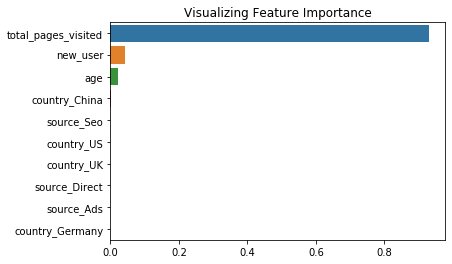

total_pages_visited    0.930490
new_user               0.042924
age                    0.023028
country_China          0.001420
source_Seo             0.000492
country_US             0.000439
country_UK             0.000409
source_Direct          0.000368
source_Ads             0.000324
country_Germany        0.000106
dtype: float64


In [53]:
# feature importance
feature_importance =pd.Series(best_random.feature_importances_,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance,y=feature_importance.index)
plt.xlabel=("Feature Importance Score")
plt.ylabel=("Features")
plt.title("Visualizing Feature Importance")
plt.show()
print(feature_importance)

In [77]:
# make predictions
train_true = Y_train
test_true=Y_test
train_pred = best_random.predict(X_train)
X_test.fillna(X_test.median(), inplace=True)
test_pred = best_random.predict(X_test)

train_fpr,train_tpr,_ = roc_curve(train_true,train_pred)
test_fpr,test_tpr,_=roc_curve(test_true,test_pred)
# _ is a variable name and it is conventional in Python to use _ for throwaway variables
# It just indicates that the loop variable is not actually used
train_auc = np.round(auc(train_fpr,train_tpr),3)
test_auc = np.round(auc(test_fpr,test_tpr),3)
# 3 is decimal in np.round

In [84]:
print("train dataset auc:" + str(train_auc)+ "\n" + "test dataset auc:" + str(test_auc))

train dataset auc:0.835
test dataset auc:0.832


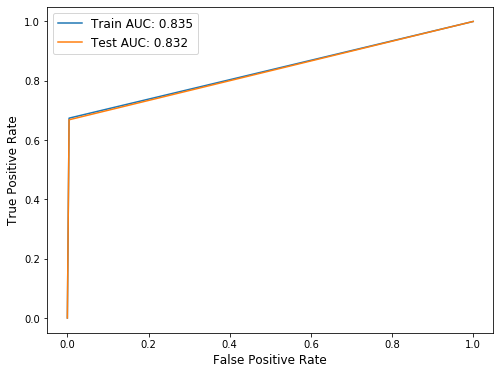

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [63]:
# investigation on missing values in X_test
X_test.isnull().any()

age                    False
new_user               False
total_pages_visited    False
country_China           True
country_Germany         True
country_UK              True
country_US              True
source_Ads              True
source_Direct           True
source_Seo              True
dtype: bool

In [67]:
X_train.isnull().any()

age                    False
new_user               False
total_pages_visited    False
country_China          False
country_Germany        False
country_UK             False
country_US             False
source_Ads             False
source_Direct          False
source_Seo             False
dtype: bool

In [68]:
X_test

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
153767,36,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
132701,20,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
172405,32,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
131780,30,1,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0
161895,43,1,5,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
72535,27,0,8,0.0,0.0,0.0,1.0,1.0,0.0,0.0
279617,32,0,11,0.0,0.0,0.0,1.0,1.0,0.0,0.0
184709,27,0,6,1.0,0.0,0.0,0.0,0.0,1.0,0.0
226900,37,1,2,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [69]:
# percentage of missing values
percent_missing=X_test.isnull().sum()*100/len(data)
missing_value=pd.DataFrame({"column_name":X_test.columns,"percent_missing":percent_missing})
missing_value.sort_values("percent_missing")
# when inplace=True is passed, the data is renamed in palce (it returns nothing); 
# when inplace=Flase(this is the default value) is passed, performs the operation and returns a copy of the object
missing_value
# there is no missing values in this project

,column_name,percent_missing
age,age,0.000000
new_user,new_user,0.000000
total_pages_visited,total_pages_visited,0.000000
country_China,country_China,0.000633
country_Germany,country_Germany,0.000633
country_UK,country_UK,0.000633
country_US,country_US,0.000633
source_Ads,source_Ads,0.000633
source_Direct,source_Direct,0.000633
source_Seo,source_Seo,0.000633


In [71]:
X_test[X_test.isnull().any(axis=1)]

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
316199,24,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316198,22,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
data.loc[316198:316199,:]

,country,age,new_user,source,total_pages_visited,converted
316198,US,22,0,Seo,4,0
316199,UK,24,0,Ads,4,0


In [86]:
# Classification Report
# classification report is another way to evaludate the classification model performance. It displays the precision, recall,
# f1 and support scores for the model
print(classification_report(Y_test,test_pred))
# the precision is teh raio tp/(tp+fp): the precision is intuitively the ability of the classifier not to label as positive a 
# sample that is negative
# the recall is tp/(tp+fn): ability of the classifier to find all the positive samples
# F-beta score reaches 1 best, 0 worest. a weighted harmonic mean of the prevision and recall
# support: the number of occurrences of each class in y_true

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91823
           1       0.84      0.67      0.74      3037

    accuracy                           0.99     94860
   macro avg       0.91      0.83      0.87     94860
weighted avg       0.98      0.99      0.98     94860



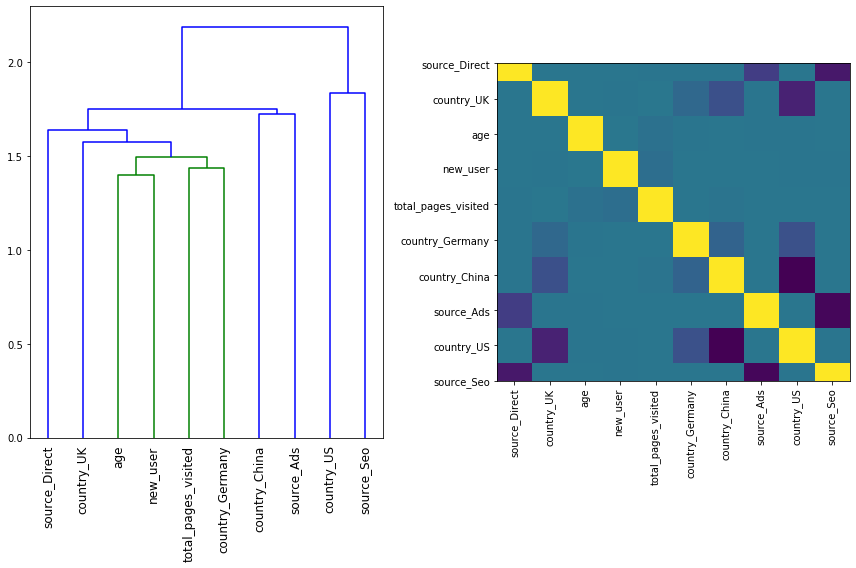

In [92]:
# heatmap of the correlated features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X_train.columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()